<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/ESAA_6_23(229_240).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 이미지 분할
이미지 분할 또는 세그멘테이션은 이미지를 구성하는 모든 픽셀에 대해 픽셀단위로 분류하는 것으로 모든 픽셏은 어떤 클래스에 속한다. 예를 들어 배경 클래스오 ㅏ객체 클래스로 구성되있다면 모두 객체 혹은 배경으로 나뉜다. 이렇게 모든 픽셀에 대한 정답 ㄹ클래스를 레이블처리한 데이터셋을 갖고 딥러닝 모델을 훈련시키면 정답클래스를 알지 못하는 새 이미지에 대해서도 배경과 객체를 분리할 수 있다.

이미지 분할은 의미분할과 인스턴스 분할로 구분되며 의미분할은 같은 범주의 여러 객체를 하나의 범줄 묶어 구분하지만 인스턴스 분할은 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념이다.

## 7-1 데이터셋 준비
이미지 분할 예제에 사용할 데이터셋은 oxford iiit pet dataset 이다. 이 데이터셋은 반료동물의 이미지 및 분류레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어 있다. 여기서 말하는 마스크는 각 픽셀에 대한 범주레이블로
class1( 반려동물이 속한 픽셀 ), class2( 반료동물고 ㅏ인접한 픽셀), class3( 위에 속하지 않은 주변 픽셀) 중 하나에 무조건 속한다.

영상처리를 위한 openCV를 비롯한 필수 라이브러리를 다음과 같이 먼저 불러온다.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
# 모델 학습에 필요한 입력이미지의 크기와 학습 파라미터 설정을 한다.
# 이방식으로 주요 파라미터를 따로 정리하면 모델의 세부 튜닝작업을 효율적으로 할 수 있다
img_w=128
img_h=128
img_c=3
img_shape = (img_w, img_h, img_c)

epoch_num=5
learning_rate=0.0001
buffer_size = 1000
batch_size=16


In [3]:
# load tensorflow dataset
ds_str = 'oxford_iiit_pet'
ds, info=tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCE3GCP/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCE3GCP/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


원본 이미지와 분할 마스크를 전처리하는 함수를 정의한다. 이미지 크기를 사전에 정의한 128, 128로 변경하고 자료형을 변경한다. 원본 이미지의 픽셀을 255로 나눠 0-1 범위로 정규화한다. 마스크는 0,1,2 정수형값을 갖도록 차감한다.

In [6]:
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [7]:
# 앞서 정의한 전처리함수를 훈련셋 테스트셋에 매핑후 미니배치로 분할한다
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


샘플배치를 한개 선택한다. 배치에는 16개이 샘플이미지와 마스크 이미지가 들어있다.

In [9]:
img, mask = next(iter(train_ds))
len(img)

16

배치에서 첫번째 이미지를 출력한다
0-1사이 값이므로 255를 다시 곱해 원래값으로 복원

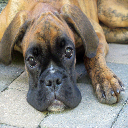

In [10]:
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

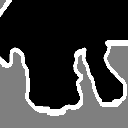

In [12]:
# print mask img
# its range is 0 to 2, dividing 2 and multipling 255 can make it expressed img
mask =(np.array(mask[0]/2))*255.0
cv2_imshow(mask)

## 7-2 U-NET model(인코더-디코더)

사전 학습된 vgg16 모델을 인코더로 활용하는 u-net 모델을 만들어본다. vgg16은 이미지넷 경진대회를 통해 성능이 검증된 모델이다. 사실 사전학습된 모델없이 u-net 을 구성하여 학습을 진행해도 학습은 된다. 단 데이터개수가 충분하고 시간이 충분하다는 전제하에 말이다.

구글 코랩환경에서 제한된 자원으로 양호한 성능을 가진 모델을 만들기 위해 사전학습된 모델을 베이스모델로 활용하는 전이학습방법을 사용하기로 한다.

먼저 vgg16 모델을 최종 레이어를 제외한채로 불러온다.

In [14]:
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

vgg16 모델은 합성곱층과 풀링층을 직렬로 연결한 구조를 갖는다. 다음 코드의 실행결과에서 모델 구조를 보면 128, 128 크기으 ㅣ텐서가 마지막 레이어에서는 4,4 크기로 축소되는 것을 확인할 수 있다.

이 모델을 u-net의 인코더로 사용한다. 인코더는 원본이미지중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소한다. 다시 말하면 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2중 하나로 분류하는 역할을 한다.



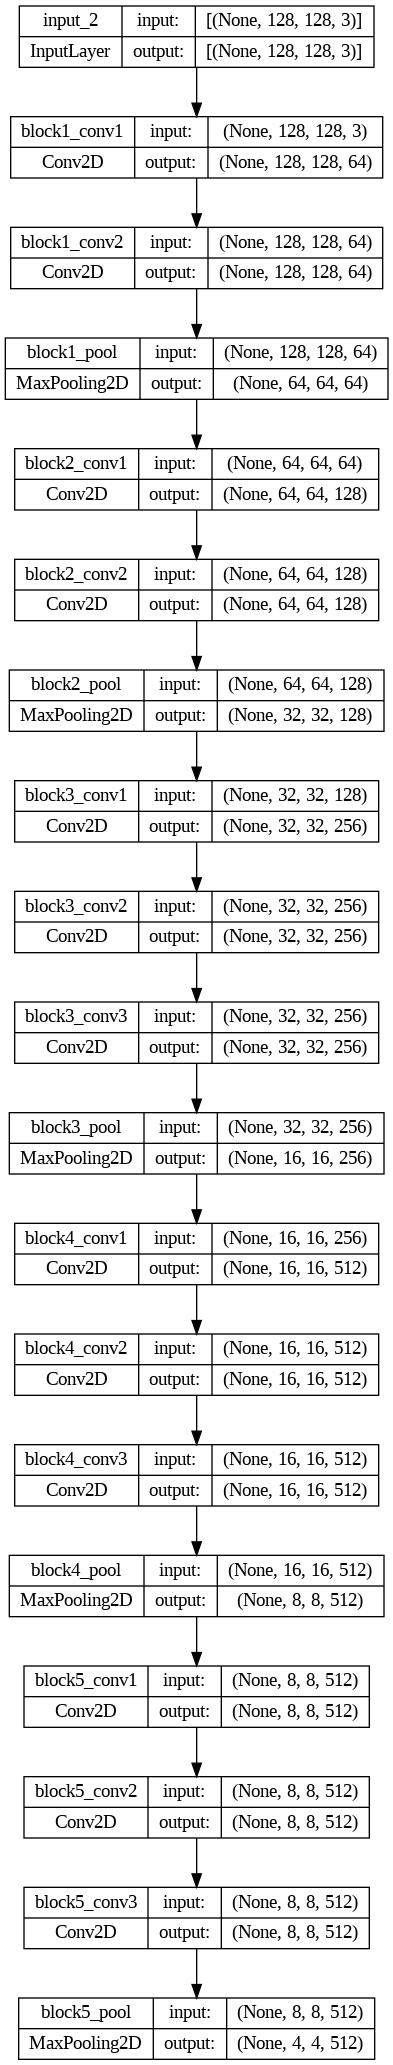

In [15]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

만들고자 하는 u-net의 모양을 미리 정하고 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정한다. VGG16 모델의 중간 레이어중 필요한 출력텐서를 지정하여 다양한 피처를 추출하는 인코더 모델을 정의하게 된다.

여기서는 vgg16 모델로붗터 5개의 출력을 가져와서 사용ㅇ한다. 다음과 같이 새로운 feature extractor 모델을 정의하고 f_model 변수에 저장한다. 1개의 입력과 5개의 출력을 갖는다.

In [16]:
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output
])

사전 학습된 파라미터를 인코더에 그대로 사용하기 위해 업데이트되지 않도록 고정한다.

In [17]:
f_model.trainable = False

인코더 부분에서 5개의 출력을 가져와 디코더의 입력으로 전달하며 업샘플링한다. 업샘플링은 축소된이미지를 원래 이미지크기로 복원한느 과정을 말한다. 제일 작은 8,8,512 텐서에서 조금씩 크기를 키워나가며 중간 출력과 합친다.

In [21]:
i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

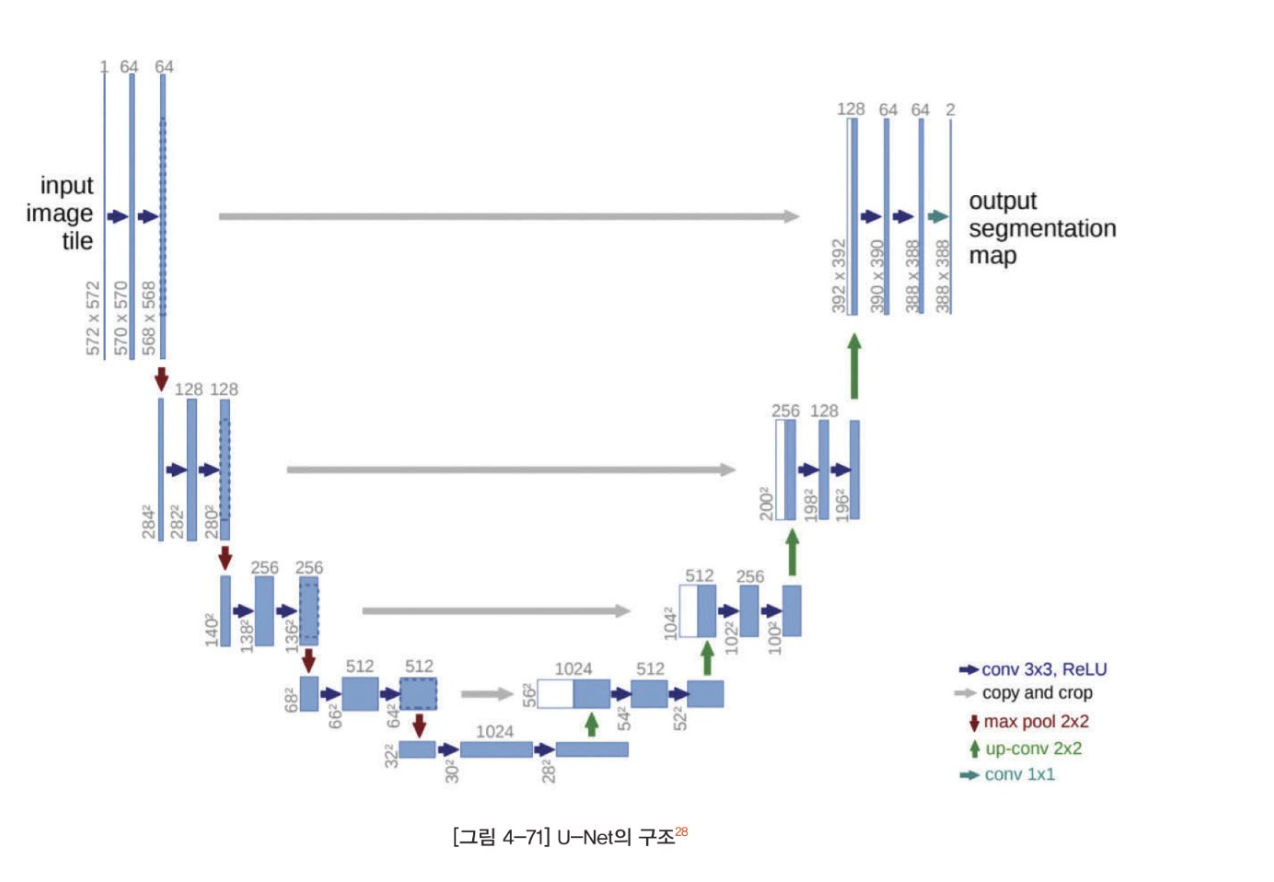

인코더의 중간출력이 업샘플링 과정에서 디코더의 중간출력과 합쳐지는 것을 확인할 수 있다. 각 레이어의 입출력 텐서크기를 잘 살펴본다.

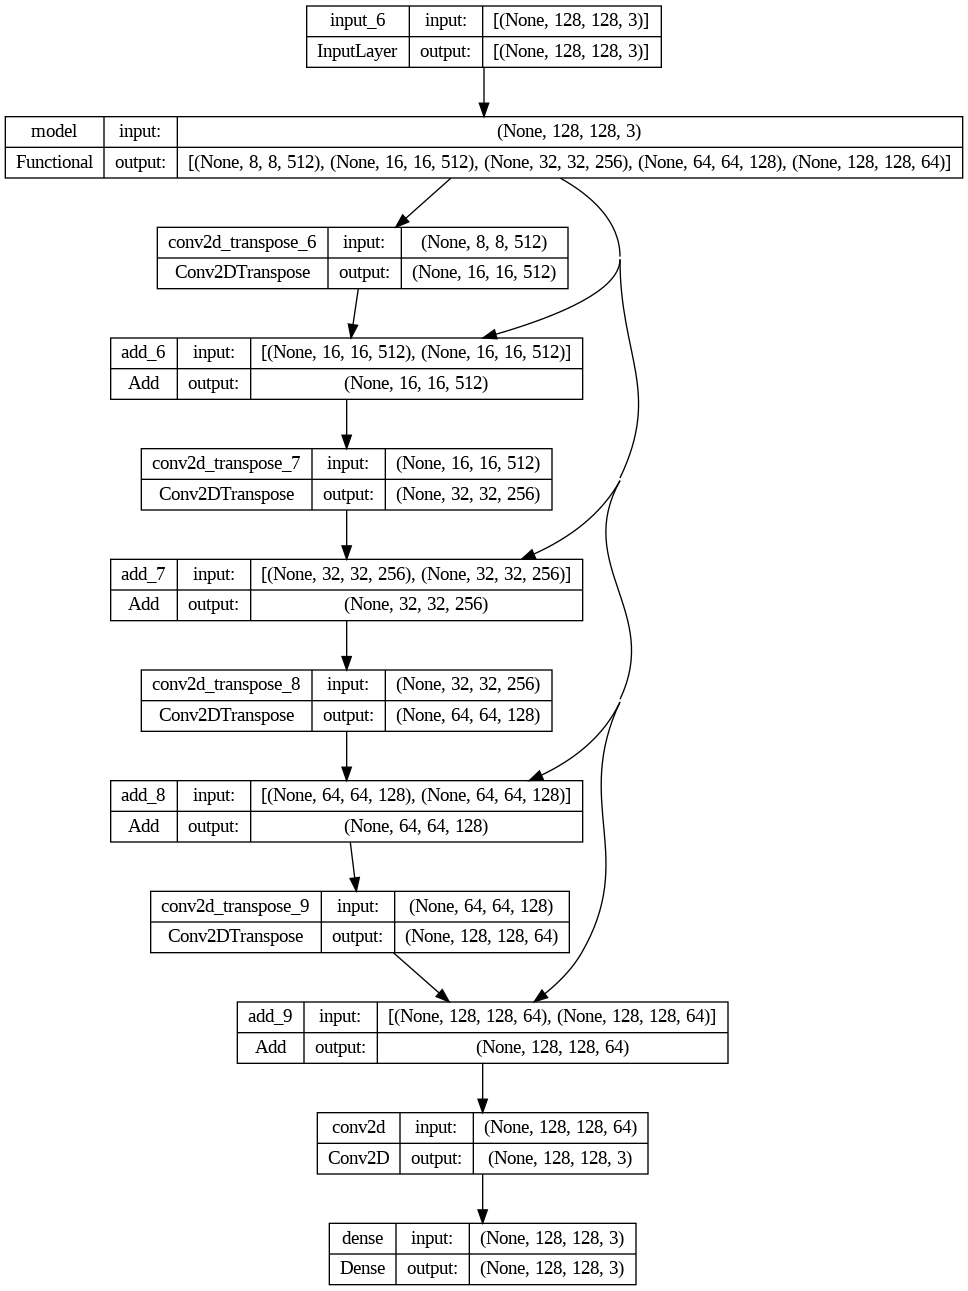

In [22]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

모델 구조 요약

인코더 출력에 사용하기 위해 fmodel로부터 유래하는 5개레이어의 1400만개 파라미터는 학습되지 않도록 고정되어 있다.

In [23]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_6[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

예측 클래스 개수가 3개인 다중분류에 맞도록 sparse categorical crossentropy 손실함수를 설정하고 ㅁ아담옵티마이저를 적용한다. 기본 성능을 확인하는 수준에서 5에폭만 훈련한다.

In [24]:
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt= tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1518s 7s/step - loss: 1.0634 - accuracy: 0.5883
Epoch 2/5
230/230 [==============================] - 1522s 7s/step - loss: 0.7109 - accuracy: 0.7622
Epoch 3/5
230/230 [==============================] - 1514s 7s/step - loss: 0.5632 - accuracy: 0.8286
Epoch 4/5
230/230 [==============================] - 1498s 6s/step - loss: 0.5092 - accuracy: 0.8431
Epoch 5/5
230/230 [==============================] - 1504s 7s/step - loss: 0.4742 - accuracy: 0.8490


검증 셋의배치를 하나 선택하고 예측 메소드로이미지 분할 클래스를 예측한다. 배치를 구성하는 16개 이미지중 첫번째 이미지의 분할결과를 노트북에 출력한다.


1/1 [==============================] - 8s 8s/step


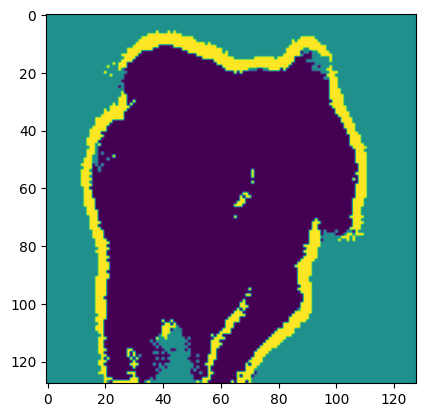

In [25]:
img, mask = next(iter(test_ds))

pred=unet_model.predict(img)

pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)


정답 마스크 이미지를 출력하고 앞서 예측한 분할이미지와 비교한다. 어느정도 객체의 경계를 찾아내는 것을 확인할 수 있다.


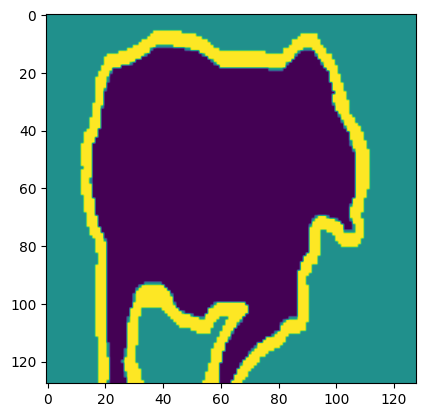

In [26]:
plt.imshow(np.reshape(mask[0], (128,128)))